リッジ回帰

訓練データ、交差検証データ、テストデータの数 = 303 101 102

αのチューニング
最適なパラメーター = {'alpha': 149.24955450518291} 精度 = 0.6901305867



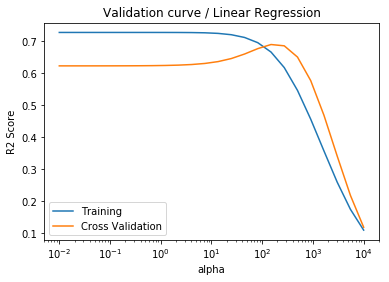

切片と係数
22.894475515
[-0.46859903  0.51250995 -0.3442444   0.94872076 -0.55979359  2.44809376
 -0.08501653 -1.08998267  0.48920143 -0.35536464 -1.38784054  0.60839819
 -2.86193018]

テストデータにフィット
テストデータの精度 = 0.771351835238

※参考
訓練データの精度 = 0.666603023327
交差検証データの精度 = 0.6901305867


In [1]:
# Qiita サポートベクター回帰（SVR）を使ってボストンの住宅価格を予測してみた
# https://qiita.com/koshian2/items/baa51826147c3d538652

## 重回帰分析（リッジ回帰）

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# データの読み込み
boston = load_boston()

# 訓練データ、テストデータに分割
X, Xtest, y, ytest = train_test_split(boston['data'], boston['target'], test_size=0.2, random_state=114514)
# 6:2:2に分割にするため、訓練データのうちの後ろ1/4を交差検証データとする
# 交差検証データのジェネレーター
def gen_cv():
    m_train = np.floor(len(y)*0.75).astype(int)#このキャストをintにしないと後にハマる
    train_indices = np.arange(m_train)
    test_indices = np.arange(m_train, len(y))
    yield (train_indices, test_indices)
# (それぞれ303 101 102 = サンプル合計は506)
print("リッジ回帰")
print()
print("訓練データ、交差検証データ、テストデータの数 = ", end="")
print(len(next(gen_cv())[0]), len(next(gen_cv())[1]), len(ytest) )
print()

# - - -

# 訓練データを基準に標準化（平均、標準偏差で標準化）
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
# テストデータも標準化
Xtest_norm = scaler.transform(Xtest)

# - - -

# ハイパーパラメータのチューニング
params = {"alpha":np.logspace(-2, 4, 24)}
gridsearch = GridSearchCV(Ridge(), params, cv=gen_cv(), scoring="r2", return_train_score=True)
gridsearch.fit(X_norm, y)
print("αのチューニング")
print("最適なパラメーター =", gridsearch.best_params_, "精度 =", gridsearch.best_score_)
print()

# - - -

# 検証曲線
plt.semilogx(params["alpha"], gridsearch.cv_results_["mean_train_score"], label="Training")
plt.semilogx(params["alpha"], gridsearch.cv_results_["mean_test_score"], label="Cross Validation")
plt.xlabel("alpha")
plt.ylabel("R2 Score")
plt.title("Validation curve / Linear Regression")
plt.legend()
plt.show()

# - - -

# チューニングしたαでフィット
regr = Ridge(alpha=gridsearch.best_params_["alpha"])
train_indices = next(gen_cv())[0]
valid_indices = next(gen_cv())[1]
regr.fit(X_norm[train_indices, :], y[train_indices])
print("切片と係数")
print(regr.intercept_)
print(regr.coef_)
print()
# テストデータの精度を計算
print("テストデータにフィット")
print("テストデータの精度 =", regr.score(Xtest_norm, ytest))
print()
print("※参考")
print("訓練データの精度 =", regr.score(X_norm[train_indices, :], y[train_indices]))
print("交差検証データの精度 =", regr.score(X_norm[valid_indices, :], y[valid_indices]))

In [2]:
## カーネルなし（線形カーネル）のサポートベクター回帰（SVR）
# データの読み込み～訓練データの標準化までの処理は、リッジ回帰と共通している

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# データの読み込み
boston = load_boston()

# 訓練データ、テストデータに分割
X, Xtest, y, ytest = train_test_split(boston['data'], boston['target'], test_size=0.2, random_state=114514)
# 6:2:2に分割にするため、訓練データのうちの後ろ1/4を交差検証データとする
# 交差検証データのジェネレーター
def gen_cv():
    m_train = np.floor(len(y)*0.75).astype(int)#このキャストをintにしないと後にハマる
    train_indices = np.arange(m_train)
    test_indices = np.arange(m_train, len(y))
    yield (train_indices, test_indices)
# (それぞれ303 101 102 = サンプル合計は506)
print("リッジ回帰")
print()
print("訓練データ、交差検証データ、テストデータの数 = ", end="")
print(len(next(gen_cv())[0]), len(next(gen_cv())[1]), len(ytest) )
print()

# - - -

# 訓練データを基準に標準化（平均、標準偏差で標準化）
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
# テストデータも標準化
Xtest_norm = scaler.transform(Xtest)

# - - -

# ハイパーパラメータのチューニング
# 計算に時間がかかるのである程度パラメーターを絞っておいた
# （1e-2～1e4まで12×12でやって最適値が'C': 0.123, 'epsilon': 1.520）
params_cnt = 20
params = {"C":np.logspace(0,1,params_cnt), "epsilon":np.logspace(-1,1,params_cnt)}
gridsearch = GridSearchCV(SVR(kernel="linear"), params, cv=gen_cv(), scoring="r2", return_train_score=True)
gridsearch.fit(X_norm, y)
print("C, εのチューニング")
print("最適なパラメーター =", gridsearch.best_params_)
print("精度 =", gridsearch.best_score_)
print()

# - - -

# チューニングしたハイパーパラメーターをフィット
regr = SVR(kernel="linear", C=gridsearch.best_params_["C"], epsilon=gridsearch.best_params_["epsilon"])
train_indices = next(gen_cv())[0]
valid_indices = next(gen_cv())[1]
regr.fit(X_norm[train_indices, :], y[train_indices])
print("切片と係数")
print(regr.intercept_)
print(regr.coef_)
print()
# テストデータの精度を計算
print("テストデータにフィット")
print("テストデータの精度 =", regr.score(Xtest_norm, ytest))
print()
print("※参考")
print("訓練データの精度 =", regr.score(X_norm[train_indices, :], y[train_indices]))
print("交差検証データの精度 =", regr.score(X_norm[valid_indices, :], y[valid_indices]))

リッジ回帰

訓練データ、交差検証データ、テストデータの数 = 303 101 102

C, εのチューニング
最適なパラメーター = {'C': 5.4555947811685188, 'epsilon': 0.42813323987193935}
精度 = 0.715406026365

切片と係数
[ 21.81797651]
[[-0.92484711  0.86695412  0.21481883  0.41999003 -1.09412238  3.61505818
  -0.57109515 -1.88140038  1.72847067 -1.61440302 -1.76307077  0.72193288
  -2.69598779]]

テストデータにフィット
テストデータの精度 = 0.834020950565

※参考
訓練データの精度 = 0.675689363164
交差検証データの精度 = 0.715406026365


ガウシアンカーネルのSVR

C, εのチューニング
最適なパラメーター = {'C': 18.329807108324356, 'epsilon': 1.4384498882876631}
精度 = 0.870461802925



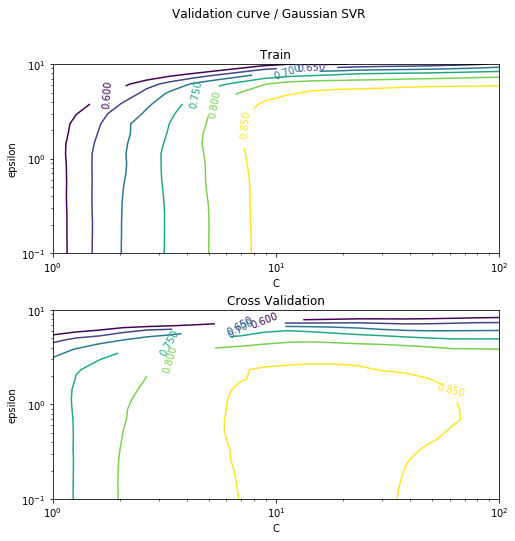

テストデータにフィット
テストデータの精度 = 0.907877172884

※参考
訓練データの精度 = 0.91960213998
交差検証データの精度 = 0.870461802925


In [3]:
## ガウシアンカーネルのサポートベクター回帰（SVR）

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

# データの読み込み
boston = load_boston()

# 訓練データ、テストデータに分割
X, Xtest, y, ytest = train_test_split(boston['data'], boston['target'], test_size=0.2, random_state=114514)
# 6:2:2に分割にするため、訓練データのうちの後ろ1/4を交差検証データとする
# 交差検証データのジェネレーター
def gen_cv():
    m_train = np.floor(len(y)*0.75).astype(int)#このキャストをintにしないと後にハマる
    train_indices = np.arange(m_train)
    test_indices = np.arange(m_train, len(y))
    yield (train_indices, test_indices)
# (それぞれ303 101 102 = サンプル合計は506)
print("ガウシアンカーネルのSVR")
print()

# 訓練データを基準に標準化（平均、標準偏差で標準化）
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
# テストデータも標準化
Xtest_norm = scaler.transform(Xtest)

# ハイパーパラメータのチューニング
params_cnt = 20
params = {"C":np.logspace(0,2,params_cnt), "epsilon":np.logspace(-1,1,params_cnt)}
gridsearch = GridSearchCV(SVR(), params, cv=gen_cv(), scoring="r2", return_train_score=True)
gridsearch.fit(X_norm, y)
print("C, εのチューニング")
print("最適なパラメーター =", gridsearch.best_params_)
print("精度 =", gridsearch.best_score_)
print()

# 検証曲線
plt_x, plt_y = np.meshgrid(params["C"], params["epsilon"])
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(hspace = 0.3)
for i in range(2):
    if i==0:
        plt_z = np.array(gridsearch.cv_results_["mean_train_score"]).reshape(params_cnt, params_cnt, order="F")
        title = "Train"
    else:
        plt_z = np.array(gridsearch.cv_results_["mean_test_score"]).reshape(params_cnt, params_cnt, order="F")
        title = "Cross Validation"
    ax = fig.add_subplot(2, 1, i+1)
    CS = ax.contour(plt_x, plt_y, plt_z, levels=[0.6, 0.65, 0.7, 0.75, 0.8, 0.85])
    ax.clabel(CS, CS.levels, inline=True)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("C")
    ax.set_ylabel("epsilon")
    ax.set_title(title)
plt.suptitle("Validation curve / Gaussian SVR")
plt.show()

# チューニングしたC,εでフィット
regr = SVR(C=gridsearch.best_params_["C"], epsilon=gridsearch.best_params_["epsilon"])
train_indices = next(gen_cv())[0]
valid_indices = next(gen_cv())[1]
regr.fit(X_norm[train_indices, :], y[train_indices])
# テストデータの精度を計算
print("テストデータにフィット")
print("テストデータの精度 =", regr.score(Xtest_norm, ytest))
print()
print("※参考")
print("訓練データの精度 =", regr.score(X_norm[train_indices, :], y[train_indices]))
print("交差検証データの精度 =", regr.score(X_norm[valid_indices, :], y[valid_indices]))